<a href="https://www.kaggle.com/code/pawarrakesh/forecast-green-energy-using-catboostregressor?scriptVersionId=111600769" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Forecast Green Energy using CATBoostRegressor

## Problem Statement

Welcome to Green - A country well known for its greenery and natural resources. Green is working towards the betterment of the environment, natural resources, and health of citizens. Over the past few years, Green has improvised its natural resources by enabling the technologies for a safer future. 

The major investment happened to be in renewable energy. As of today, renewable energy contributes to 60% of the total energy capacity in the country. By 2030, the target is to generate 95% of the total energy through renewable energy.

In order to achieve this objective, the government of Green Energy would like to use Data Science to understand the total energy demand of the country in the near future. This will help the government to build the infrastructure and technologies to achieve 95% of the total energy capacity via renewable energy.

They have captured the estimated total energy demand from the past 12 years on an hourly basis. Now, the government of Green Energy is looking for a data scientist to understand the data and forecast the total energy demand for the next 3 years based on past trends.

## Objective

Your task at hand is to build a machine learning/deep learning approach to forecast the total energy demand on an hourly basis for the next 3 years based on past trends.


In [1]:
import pandas as pd                                          #  for reading CSV
import numpy as np                                           # for numeric calculation
import matplotlib.pyplot as plt                              # Ploting Graph
import seaborn as sns
from sklearn.metrics import mean_squared_error               # return RMSE from given param
import warnings
warnings.filterwarnings("ignore")                            # ignore warning 

In [2]:
# read train and test 
train_df = pd.read_csv('../input/forecast-green-energy-dataset/train.csv')            
test_df = pd.read_csv('../input/forecast-green-energy-dataset/test.csv')


In [3]:
#Identify the datatype of variables
train_df.dtypes

row_id        int64
datetime     object
energy      float64
dtype: object

In [4]:
# convert datatype to datetime 
train_df.datetime=pd.to_datetime(train_df.datetime, dayfirst=True)
test_df.datetime=pd.to_datetime(test_df.datetime, dayfirst=True)

# set datetime column as index of Dataframe
train_df=train_df.set_index('datetime')           
test_df=test_df.set_index('datetime')

In [5]:
test_df.head(2)                   # top 2 rows

,row_id
datetime,
2019-01-01 00:00:00,94993
2019-01-01 01:00:00,94994


In [6]:
train_df.head(2)              

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500


## Dealing with null values

In [7]:
#check the total number of null values in each column 
train_df.isnull().sum()          

row_id       0
energy    1900
dtype: int64

In [8]:
# checking description
train_df.energy.describe()

count    93092.000000
mean      1702.995014
std        369.322103
min        866.388600
25%       1431.541100
50%       1654.465800
75%       1935.993450
max       3374.399600
Name: energy, dtype: float64

<AxesSubplot:xlabel='energy', ylabel='Density'>

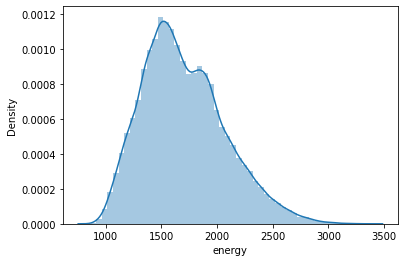

In [9]:
# how data is peak before dealing with null values
sns.distplot(train_df.energy)

In [10]:
# making copy of original the train data

df1=train_df.copy()
df1.isna().sum()

row_id       0
energy    1900
dtype: int64

<AxesSubplot:xlabel='energy', ylabel='Density'>

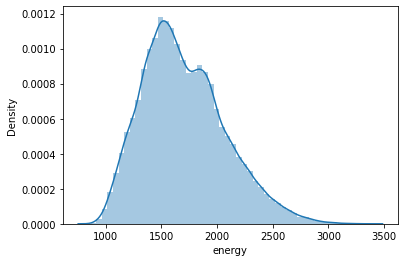

In [11]:
# fiiling previous value in place of nan value

df1.energy=df1.energy.fillna(method='backfill')
sns.distplot(df1.energy) 

- After dealing with null values, the peakness of data is the same

In [12]:
df1.isnull().sum()

row_id    0
energy    0
dtype: int64

In [13]:
df1.head(2)

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500


In [14]:
# making clean copies of the train and the test data 
train=df1
test=test_df

In [15]:
train.tail()

,row_id,energy
datetime,,
2018-12-31 19:00:00,94988,2528.4468
2018-12-31 20:00:00,94989,2461.8836
2018-12-31 21:00:00,94990,2365.9944
2018-12-31 22:00:00,94991,2342.9428
2018-12-31 23:00:00,94992,2180.2176


In [16]:
test.tail()

,row_id
datetime,
2021-12-31 19:00:00,121292
2021-12-31 20:00:00,121293
2021-12-31 21:00:00,121294
2021-12-31 22:00:00,121295
2021-12-31 23:00:00,121296


# Solving ML challenge using CatBoost Regressor

- CatBoost is a recently open-sourced machine learning algorithm from Yandex. It can easily integrate with deep learning frameworks like Google’s TensorFlow and Apple’s Core ML.
- It can work with diverse data types to help solve a wide range of problems that businesses face today. To top it up, it provides best-in-class accuracy.

In [17]:
# creating a function for splitting datetime into multiple features

def create_features(df):        
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df1)

In [18]:
df.head()

,row_id,energy,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
datetime,,,,,,,,,,
2008-03-01 00:00:00,1,1259.985563,0,5,1,3,2008,61,1,9
2008-03-01 01:00:00,2,1095.541500,1,5,1,3,2008,61,1,9
2008-03-01 02:00:00,3,1056.247500,2,5,1,3,2008,61,1,9
2008-03-01 03:00:00,4,1034.742000,3,5,1,3,2008,61,1,9
2008-03-01 04:00:00,5,1026.334500,4,5,1,3,2008,61,1,9


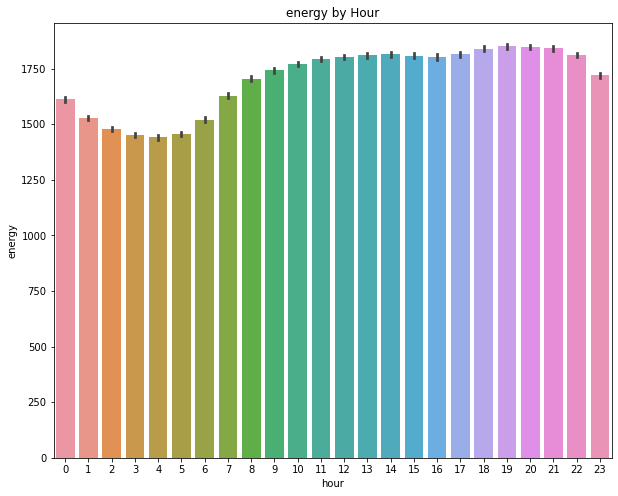

In [19]:
# Visualizing energy utilization 
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df, x='hour', y='energy')
ax.set_title('energy by Hour')
plt.show()

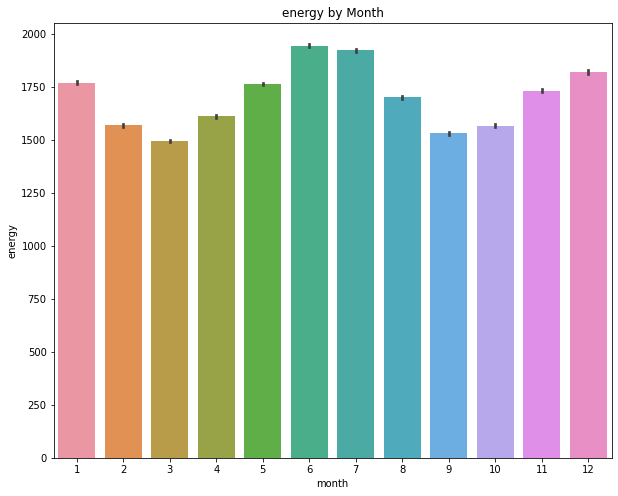

In [20]:
# Visualizing energy utilization 
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=df, x='month', y='energy')
ax.set_title('energy by Month')
plt.show()

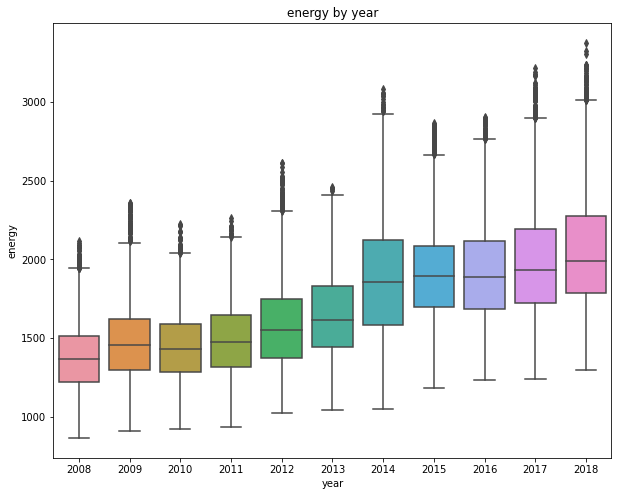

In [21]:
# Visualizing energy utilization 
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y='energy')
ax.set_title('energy by year')
plt.show()

In [22]:
# Prepressing and normalizing data with sklearn 

from sklearn.preprocessing import Normalizer
scaler = Normalizer()

In [23]:
# making features with create_features function by passing parameters

train = create_features(df1)

test = create_features(test)


In [24]:
train.columns

Index(['row_id', 'energy', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [25]:
# select features from train dataset and transform 
X=train[['hour','dayofweek', 'month','year','dayofyear', 'dayofmonth', 'weekofyear']]
X= scaler.fit_transform(X)

In [26]:
# select fratures from test data
test1=test[['hour','dayofweek', 'month','year','dayofyear', 'dayofmonth', 'weekofyear']]
test1=scaler.fit_transform(test1)

In [27]:
# Target Variable
y=train['energy']

In [28]:
# spliting data into test and train with 20% test data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size = 0.2,random_state=1)

In [29]:
X_test.shape

(18999, 7)

In [30]:
test.shape

(26304, 9)

In [31]:
from catboost import CatBoostRegressor
cbr=CatBoostRegressor(loss_function='RMSE')

## Building Model

In [32]:
cbr.fit(X_train,y_train,eval_set=(X_test,y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.100503
0:	learn: 357.3429123	test: 357.1308040	best: 357.1308040 (0)	total: 66.1ms	remaining: 1m 6s
1:	learn: 346.8372816	test: 346.8933673	best: 346.8933673 (1)	total: 74.7ms	remaining: 37.3s
2:	learn: 337.8878656	test: 337.9486486	best: 337.9486486 (2)	total: 83.7ms	remaining: 27.8s
3:	learn: 329.7440875	test: 329.8705362	best: 329.8705362 (3)	total: 92.8ms	remaining: 23.1s
4:	learn: 323.1085480	test: 323.2086319	best: 323.2086319 (4)	total: 101ms	remaining: 20.1s
5:	learn: 317.4355008	test: 317.5434869	best: 317.5434869 (5)	total: 110ms	remaining: 18.2s
6:	learn: 313.0016262	test: 313.1092358	best: 313.1092358 (6)	total: 119ms	remaining: 16.9s
7:	learn: 308.0108671	test: 308.0556955	best: 308.0556955 (7)	total: 128ms	remaining: 15.8s
8:	learn: 303.0554558	test: 303.1202377	best: 303.1202377 (8)	total: 136ms	remaining: 15s
9:	learn: 299.4358860	test: 299.5667532	best: 299.5667532 (9)	total: 145ms	remaining: 14.4s
10:	learn: 295.6710868	test: 295.7161809	best: 2

In [33]:
# Model Score
y_pred_cbr=cbr.predict(X_test)
cbr.score(X_train,y_train)

0.9384473274446542

In [34]:
# checking R^2 
from sklearn.metrics import r2_score
r2_score(y_test ,y_pred_cbr)

0.9361188366160307

In [35]:
# creating a function to create adhusted R-Squared

def adj_r2(X, y, model):
    pred=cbr.predict(X)
    r2 = r2_score(y,pred)
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return adjusted_r2

In [36]:
# adhusted R-Squared for train data
print(adj_r2(X_train, y_train, y_pred_cbr))

0.9384416570003837


In [37]:
# adhusted R-Squared for trat data
print(adj_r2(X_test, y_test, y_pred_cbr))

0.936095290297054


 #### As depicted above we achieve an R-squared of 94% on our test set, which is quite good, considering the minimal feature engineering.



In [38]:
# RMSE
cbr.get_best_score()

{'learn': {'RMSE': 91.63445443120992},
 'validation': {'RMSE': 93.26665583696828}}

## Error Metrics

Mean Absolute Error: 71.52507826690783
Mean Squared Error: 8698.668962622398
Root Mean Squared Error: 93.26665514867786


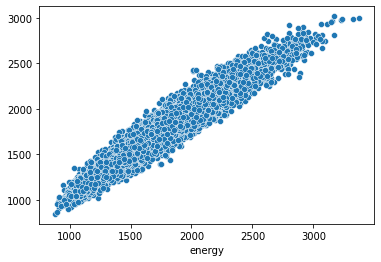

In [39]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test ,y_pred_cbr))
print('Mean Squared Error:', metrics.mean_squared_error(y_test ,y_pred_cbr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test ,y_pred_cbr)))
sns.scatterplot(y_test ,y_pred_cbr)
plt.show()

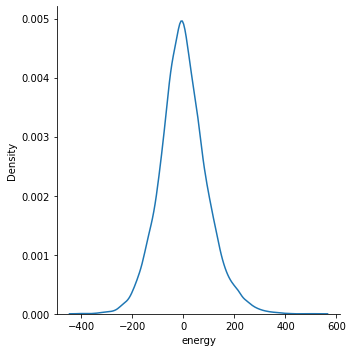

In [40]:
# Residual
residual = y_test - y_pred_cbr
sns.displot(residual,kind='kde')

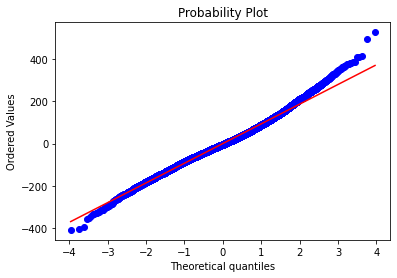

In [41]:
# QQ plot to check relation between predicted and actual values
import scipy as sp
fig, ax = plt.subplots(figsize=(6,4))
sp.stats.probplot(residual, plot=ax, fit=True)

plt.show()

## Feature Importance

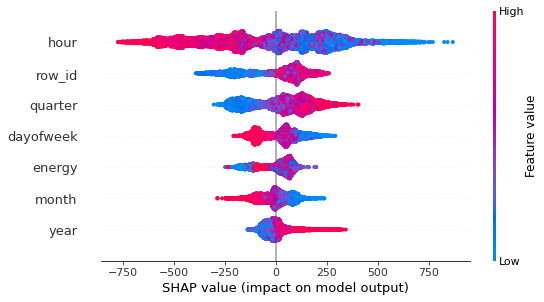

In [42]:
import shap
explainer = shap.TreeExplainer(cbr)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test,feature_names = (train.columns))

Text(0.5, 1.0, 'SHAP Importance')

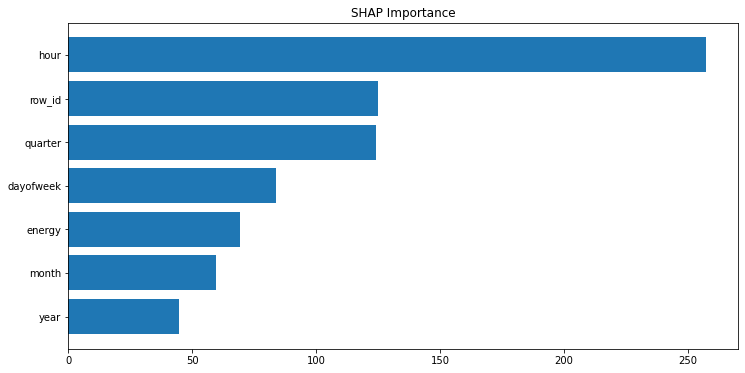

In [43]:
explainer = shap.Explainer(cbr)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
plt.title('SHAP Importance')

evaluation as per the above evaluation, I can say that our model is performing well with an overall 94% performance accuracy.

Now,I am applying a model on test data for predicting future value of energy utilization.

## Apply model on test dataset

In [44]:
# predict energy utilization for test dataset
test_df['energy']=cbr.predict(test1)
test_df

,row_id,energy
datetime,,
2019-01-01 00:00:00,94993,1825.716682
2019-01-01 01:00:00,94994,1729.883384
2019-01-01 02:00:00,94995,1627.559881
2019-01-01 03:00:00,94996,1600.966291
2019-01-01 04:00:00,94997,1573.887527
...,...,...
2021-12-31 19:00:00,121292,2283.186039
2021-12-31 20:00:00,121293,2224.957909
2021-12-31 21:00:00,121294,2169.645295


In [45]:
final=test_df[['row_id','energy']]
final.head()

,row_id,energy
datetime,,
2019-01-01 00:00:00,94993,1825.716682
2019-01-01 01:00:00,94994,1729.883384
2019-01-01 02:00:00,94995,1627.559881
2019-01-01 03:00:00,94996,1600.966291
2019-01-01 04:00:00,94997,1573.887527


## load predicted data 

In [46]:

final.to_csv('energy-CBR-final-perc.csv',index=False)